In [1]:
### Imports
# Modules
import csv
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Utilities
from imgaug import augmenters as iaa
from random import random
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from utils import crop_resize

# Keras
from keras.models import Sequential, load_model
from keras.layers import Flatten, Dense, Lambda, Cropping2D, Conv2D, Dropout
from keras.regularizers import l2

# Plot in the notebook
%matplotlib inline

Using TensorFlow backend.


In [2]:
# Constants
DATA_DIR = 'data/'
CSV_FILE = 'driving_log.csv'

# Generator parameters
BATCH_SIZE = 32

# Augmentation parameters
angle_treshold = 0.1
zero_discard_prob = 0.9
angle_keep_prob = 0.1

# Parameters
steering_correction = 0.25

In [3]:
# Load csv log file
csv_file = []
with open(DATA_DIR+CSV_FILE) as csvfile:
    reader = csv.reader(csvfile)
    next(reader, None)  # skip the headers
    for line in reader:
        csv_file.append(line)

In [4]:
# Split csv in train and validation sets
csv_train, csv_valid = train_test_split(csv_file, test_size = 0.2)

In [5]:
# Load images and steering data
images = []
measurements = []
for line in csv_file:
    source_path = 'data/' + line[0]
    image = cv2.imread(source_path)
    images.append(image)
    measurement = float(line[3])
    measurements.append(measurement)
X_train = np.array(images)
y_train = np.array(measurements)

In [6]:
# Image transformations
# Transformation list:
tr_list = [iaa.Add((-75, 75)), # change brightness of images (by -10 to 10 of original value)
           iaa.Multiply((0.5, 2.0)),
           iaa.ContrastNormalization((0.5, 2.0)), # improve or worsen the contrast
           iaa.Dropout((0.01, 0.1), per_channel=0.5), # randomly remove up to 10% of the pixels
           iaa.AdditiveGaussianNoise(scale=(0, 0.1*255))]
seq = iaa.SomeOf((0, 2), tr_list)

In [7]:
# Get sample image for testing
sample_idx = np.random.choice(len(csv_file))
path = DATA_DIR + csv_file[sample_idx][0].strip()
sample_image = cv2.imread(path)
sample_angle = csv_file[sample_idx][3]

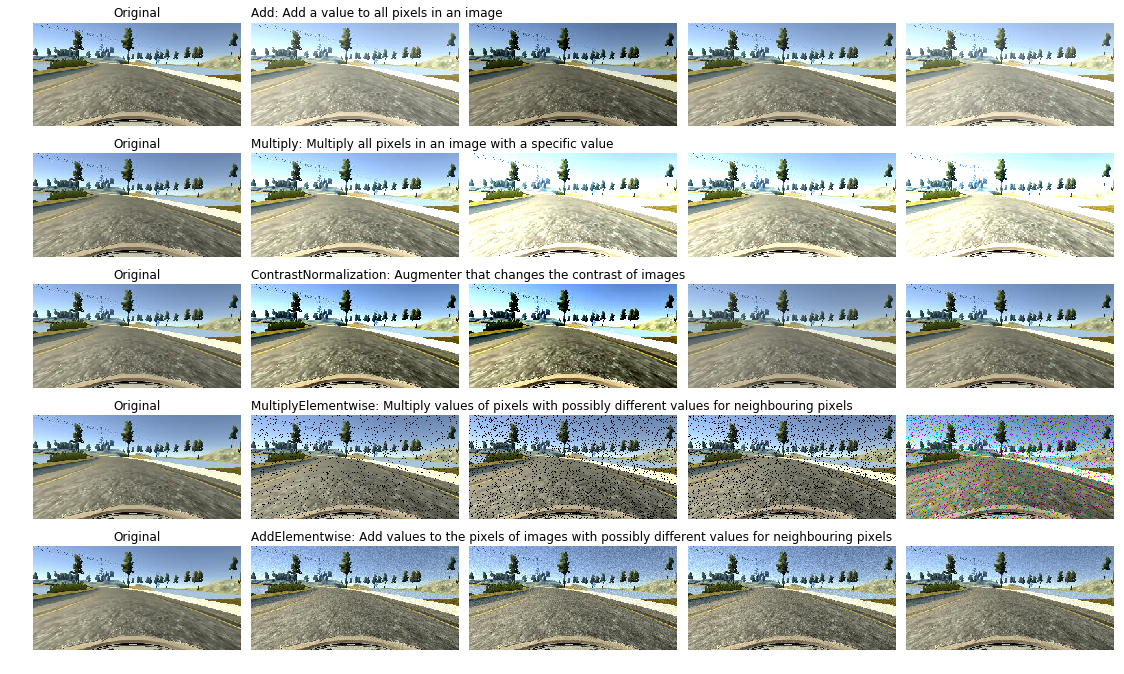

In [8]:
### Test image transformations
# Graph paramters
plot_width, plot_height = 15, 9
grid_rows, grid_cols = 5, 5
sample_size = grid_rows * grid_cols 

# Plot 
fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for tr_fn in tr_list:
    # Print non-transformed image
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    imgplt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title('Original')
    counter += 1
    # Print transformed images
    tr_images = tr_fn.augment_images([sample_image]*(grid_cols-1))
    print_title = True
    for tr_image in tr_images:
        imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
        imgplt.imshow(cv2.cvtColor(tr_image, cv2.COLOR_BGR2RGB))
        imgplt.axis('off')
        if print_title:
            imgplt.set_title('{}: {}'.format(tr_fn.name[7:],' '.join(tr_fn.__doc__.split('.')[0].split())), loc='left')
            print_title = False
        counter += 1

In [9]:
def generator(csv_file, batch_size = BATCH_SIZE):
    num_samples = len(csv_file)
    while 1: # Loop forever so the generator never terminates
        shuffle(csv_file)
        for offset in range(0, num_samples, batch_size):
            batch_samples = csv_file[offset:offset+batch_size]

            images = []
            angles = []
            for batch_sample in batch_samples:
                name = DATA_DIR + batch_sample[0].strip()
                center_image = cv2.imread(name)
                center_angle = float(batch_sample[3])
                images.append(center_image)
                angles.append(center_angle)

            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

In [ ]:
def generator(csv_file, batch_size = BATCH_SIZE, image_load = True):
    
    # Camera parameters
    cameras = ['center', 'left', 'right']
    cameras_index = {'center':0, 'left':1, 'right':2} # 0:center, 1:left, 2:right
    cameras_steering_corretion = {'center':0, 'left':steering_correction, 'right':-steering_correction}
    
    num_samples = len(csv_file)
    while 1: # Loop forever so the generator never terminates
        shuffle(csv_file)
        counter = 0
        images = []
        angles = []
        for idx in range(0, num_samples):
            angle = float(csv_file[idx][3])
            ### Discard angles below treshold with certain prob
            if angle < angle_treshold and random() < zero_discard_prob:
                continue
            counter += 1

            ### Randomly choose center, left or right image
            # Get random camera 0:center, 1:left, 2:right 
            camera = np.random.choice(cameras)
            path = DATA_DIR + csv_file[idx][cameras_index[camera]].strip()
            if image_load:
                image = cv2.imread(path)
            else:
                image = np.zeros((160, 320, 3), dtype = np.uint8)
            # Adjust angle
            angle += cameras_steering_corretion[camera]            
            
            ### Random flip image with 0.5 prob
            if random() > 0.5:
                image = cv2.flip(image,1)
                angle *= -1.    
                        
            images.append(image)
            angles.append(angle)

            if counter == batch_size:
                X_train = np.array(images)                
                if image_load:
                    X_train = seq.augment_images(X_train)
                y_train = np.array(angles)
                counter = 0
                images = []
                angles = []                

                yield shuffle(X_train, y_train)

In [ ]:
for images, angles in generator(csv_train):
    break
print(images.shape)

In [ ]:
def transformed_data_generator(csv_file, batch_size = BATCH_SIZE, image_load = True):

    # Camera parameters
    cameras = ['center', 'left', 'right']
    cameras_index = {'center':0, 'left':1, 'right':2} # 0:center, 1:left, 2:right
    cameras_steering_corretion = {'center':0, 'left':steering_correction, 'right':-steering_correction}
    
    batch_train = np.zeros((batch_size, 160, 320, 3), dtype = np.uint8)
    batch_angle = np.zeros((batch_size,), dtype = np.float32)
    
    # Loop to generate data
    while True:

        # Shuffle data
        shuffle(csv_file)        
        
        # Generate data poins
        for idx in range(batch_size):
            
            # Get random csv line
            while True:
                line_idx = np.random.choice(len(csv_file))
                angle = float(csv_file[line_idx][3])
                # If angle above treshold get it
                if angle > angle_treshold:
                    break
                # if below, discard with certain prob
                elif random() > zero_discard_prob:
                    break   
            
            ### Randomly choose center, left or right image
            # Get random camera 0:center, 1:left, 2:right 
            camera_idx = np.random.choice(3)
            # Load image
            path = DATA_DIR + csv_file[line_idx][camera_idx].strip()
            if image_load:
                image = cv2.imread(path)
                batch_train[idx] = image
            # Adjust angle
            shift_angle = [0, 0.25, -0.25][camera_idx]
            batch_angle[idx] = angle + shift_angle
            
            ### Randomly flip
            # If flip image with 0.5 prob
            if random() > 0.5:
                batch_train[idx] = cv2.flip(batch_train[idx],1)
                batch_angle[idx] *= -1
        
        ### Random image transformation
        # up to two of the following transformations:
        # Bright augmentation
        # Multiply
        # Contrast normalization
        # Dropout ()
        # Additive Gaussian Noise
        if image_load:
            batch_train = seq.augment_images(batch_train)
            
        yield batch_train, batch_angle

In [ ]:
def original_data_generator(csv_file, batch_size = BATCH_SIZE, image_load = True):
    
    batch_train = np.zeros((batch_size, 160, 320, 3), dtype = np.uint8)
    batch_angle = np.zeros((batch_size,), dtype = np.float32)
    while True:
        
        # Shuffle data in each batch
        shuffle(csv_file)
        
        for idx in range(batch_size):
            # Get random csv line
            line_idx = np.random.choice(len(csv_file))
            # Load image 
            path = DATA_DIR + csv_file[line_idx][0].strip()
            if image_load:
                batch_train[idx] = cv2.imread(path)
            # Load angle
            batch_angle[idx] = float(csv_file[line_idx][3])          
            
        yield batch_train, batch_angle

In [ ]:
train_data_generator = generator(csv_train)
valid_data_generator = original_data_generator(csv_valid)

In [ ]:
for images, angles in train_data_generator:
    break

plot_width, plot_height = 15, 5
grid_rows, grid_cols = 4, 8

fig = plt.figure(figsize = (plot_width, plot_height))
fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)
counter = 1
for image, angle in zip(images, angles):
    imgplt = fig.add_subplot(grid_rows, grid_cols, counter)
    counter += 1
    imgplt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    imgplt.axis('off')
    imgplt.set_title(angle)

In [ ]:
zero_discard_prob = 0.95
sample_size = 100

tr_angles = []
counter = 0
for images, angles in generator(csv_train, image_load = False):
    counter += 1
    tr_angles = np.concatenate((tr_angles, angles))
    if counter > sample_size: break

or_angles = []
counter = 0
for images, angles in original_data_generator(csv_train, image_load = False):
    counter += 1
    or_angles = np.concatenate((or_angles, angles))
    if counter > sample_size: break        
        
buckets = np.arange(-1,1,0.05)

fig = plt.figure(figsize = (12, 3))
#fig.subplots_adjust(left = 0, right = 1, bottom = 0, top = 1, hspace = 0.05, wspace = 0.05)

hstplt = fig.add_subplot(1, 2, 1)
hist = hstplt.hist(or_angles, bins = buckets)

hstplt = fig.add_subplot(1, 2, 2)
hist = hstplt.hist(tr_angles, bins = buckets)

In [ ]:
def create_nv_model():
    # Define nvidia model
    nv_model = Sequential()
    nv_model.add(Cropping2D(cropping=((30,25),(0,0)), input_shape = (160, 320, 3)))
    nv_model.add(Lambda(lambda x: x / 255.0 - 0.5))
    nv_model.add(Conv2D(24, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu'))
    nv_model.add(Conv2D(36, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu'))
    nv_model.add(Conv2D(48, (5, 5), padding = 'valid', strides = (2, 2), activation = 'relu'))
    nv_model.add(Conv2D(64, (3, 3), padding = 'same', strides = (2, 2), activation = 'relu'))
    nv_model.add(Conv2D(64, (3, 3), padding = 'valid', strides = (2, 2), activation = 'relu'))
    nv_model.add(Flatten())
    nv_model.add(Dense(80))
    nv_model.add(Dropout(0.5))
    nv_model.add(Dense(40))
    nv_model.add(Dropout(0.5))
    nv_model.add(Dense(16))
    nv_model.add(Dropout(0.5))
    nv_model.add(Dense(10))
    nv_model.add(Dense(1))
    # nv_model.summary()
    nv_model.compile(loss = 'mse', optimizer = 'adam')
    return nv_model

In [ ]:
nv_model = create_nv_model()
nv_history_object = nv_model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, epochs = 10)
for images, angles in valid_data_generator:
    break
steering_angles = nv_model.predict(images)
print(steering_angles.T)

In [ ]:
for pred_angle, angle in zip (steering_angles, angles):
    print('{:f}\t{:f}\t{:f}'.format(pred_angle[0], angle, abs(pred_angle[0] - angle)))

In [ ]:
X_gen_train = np.empty((0,160,320,3))
y_gen_train = np.array(())
counter = 0
limit = 100
for images, angles in train_data_generator:
    X_gen_train = np.concatenate((X_gen_train, images))
    y_gen_train = np.concatenate((y_gen_train, angles))
    counter += 1
    if counter >= limit: break
X_gen_train = np.array(X_gen_train)
y_gen_train = np.array(y_gen_train)
print(X_gen_train.shape)
print(y_gen_train.shape)

In [ ]:
nv_model = create_nv_model()
nv_history_object = nv_model.fit(X_gen_train, y_gen_train, validation_split = 0.2, shuffle = True, epochs = 10)
for images, angles in valid_data_generator:
    break
steering_angles = nv_model.predict(images)
print(steering_angles.T)

In [ ]:
for pred_angle, angle in zip (steering_angles, angles):
    print('{:f}\t{:f}\t{:f}'.format(pred_angle[0], angle, abs(pred_angle[0] - angle)))

In [ ]:
nv_model = create_nv_model()
nv_history_object = nv_model.fit_generator(generator(csv_train), steps_per_epoch = len(csv_train)/BATCH_SIZE,
                                 epochs=10, #FLAGS.epochs,
                                 validation_data = valid_data_generator, validation_steps = len(csv_valid)/BATCH_SIZE)
steering_angles = nv_model.predict(images)
print(steering_angles.T)

In [ ]:
for pred_angle, angle in zip (steering_angles, angles):
    print('{:f}\t{:f}\t{:f}'.format(pred_angle[0], angle, abs(pred_angle[0] - angle)))

In [ ]:
# Save model
model.save('nv_model.h5')

In [ ]:
### plot the training and validation loss for each epoch
plt.plot(nv_history_object.history['loss'])
plt.plot(nv_history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')

In [ ]:
# Define simple model
simple_model = Sequential()
simple_model.add(Lambda(lambda x: x / 255.0 - 0.5, input_shape = (160, 320, 3)))
simple_model.add(Flatten(input_shape= (160, 320, 3)))
simple_model.add(Dense(1))
simple_model.compile(loss = 'mse', optimizer = 'adam')

In [ ]:
simple_model.fit(X_train, y_train, validation_split = 0.2, shuffle = True, epochs = 5)
for images, angles in valid_data_generator:
    break
steering_angles = simple_model.predict(images)
print(steering_angles.T)

In [ ]:
simple_history_object = simple_model.fit_generator(train_data_generator, steps_per_epoch = len(csv_train)/BATCH_SIZE,
                                 epochs=5, #FLAGS.epochs,
                                 validation_data = valid_data_generator, validation_steps = len(csv_valid)/BATCH_SIZE)
for images, angles in valid_data_generator:
    break
steering_angles = simple_model.predict(images)
print(steering_angles.T)

In [ ]:
print(angles.T)

In [ ]:
# Save model
model.save('simple_model.h5')